In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

plt.style.use("seaborn-v0_8")


In [23]:
df = pd.read_csv("world_bank_data_2025.csv")

print("Shape:", df.shape)
print(df.head())
print("\nColumns:", df.columns)


Shape: (3472, 16)
  country_name country_id  year  Inflation (CPI %)  GDP (Current USD)  \
0        Aruba         aw  2010           2.078141       2.453597e+09   
1        Aruba         aw  2011           4.316297       2.637859e+09   
2        Aruba         aw  2012           0.627472       2.615208e+09   
3        Aruba         aw  2013          -2.372065       2.727850e+09   
4        Aruba         aw  2014           0.421441       2.790850e+09   

   GDP per Capita (Current USD)  Unemployment Rate (%)  \
0                  24093.140151                    NaN   
1                  25712.384302                    NaN   
2                  25119.665545                    NaN   
3                  25813.576727                    NaN   
4                  26129.839062                    NaN   

   Interest Rate (Real, %)  Inflation (GDP Deflator, %)  \
0                11.666131                    -1.223407   
1                 4.801974                     4.005674   
2                

In [24]:
features = [
    "Inflation (CPI %)",
    "GDP per Capita (Current USD)",
    "GDP Growth (% Annual)",
    "Unemployment Rate (%)",
    "Interest Rate (Real, %)",
    "Public Debt (% of GDP)"
]

In [26]:
latest_year = df["year"].max()
df_year = df[df["year"] == latest_year].copy()
df_cluster = df_year[features].dropna()

print(f"\nLatest year: {latest_year}")
print("Rows in latest year:", df_year.shape[0])
print("Rows used for clustering (latest year, after dropna):", df_cluster.shape[0])

# If empty, fall back to using ALL YEARS
if df_cluster.shape[0] == 0:
    print("\n[INFO] Latest year has no complete rows for these features.")
    print("[INFO] Falling back to using ALL years instead.")
    df_cluster = df[features].dropna()
    print("Rows used for clustering (all years, after dropna):", df_cluster.shape[0])


Latest year: 2025
Rows in latest year: 217
Rows used for clustering (latest year, after dropna): 0

[INFO] Latest year has no complete rows for these features.
[INFO] Falling back to using ALL years instead.
Rows used for clustering (all years, after dropna): 547


In [27]:
print("\nMissing values per feature (full df):")
print(df[features].isna().sum())



Missing values per feature (full df):
Inflation (CPI %)                778
GDP per Capita (Current USD)     534
GDP Growth (% Annual)            560
Unemployment Rate (%)            677
Interest Rate (Real, %)         1737
Public Debt (% of GDP)          2620
dtype: int64


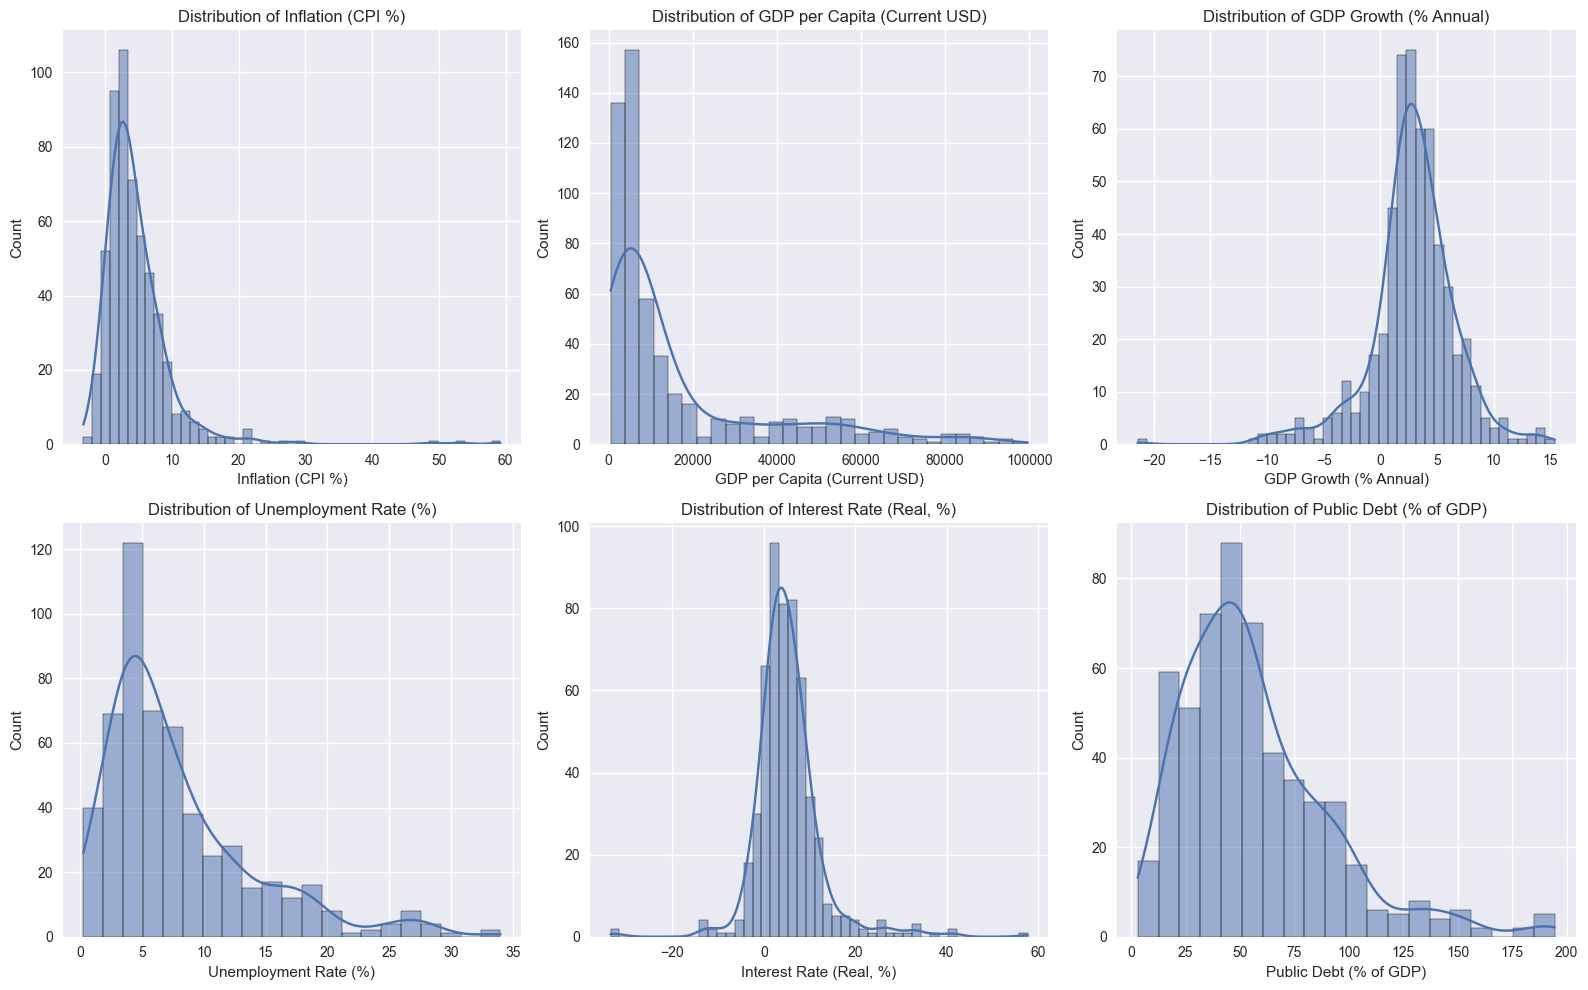

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for i, col in enumerate(features):
    sns.histplot(df_cluster[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()

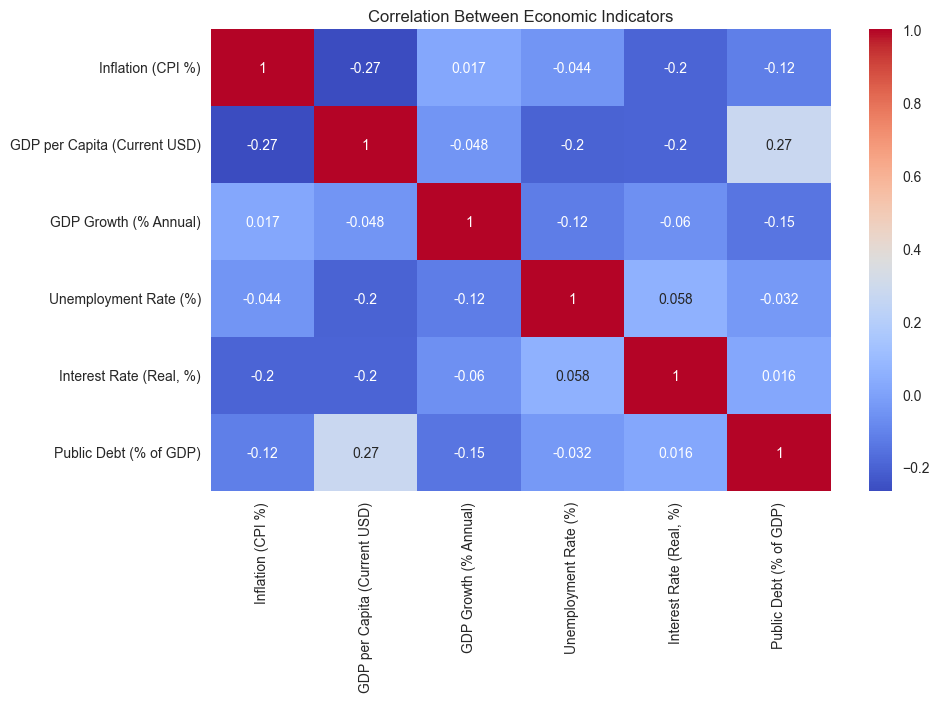

In [29]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cluster[features].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Between Economic Indicators")
plt.show()

In [30]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_cluster[features])


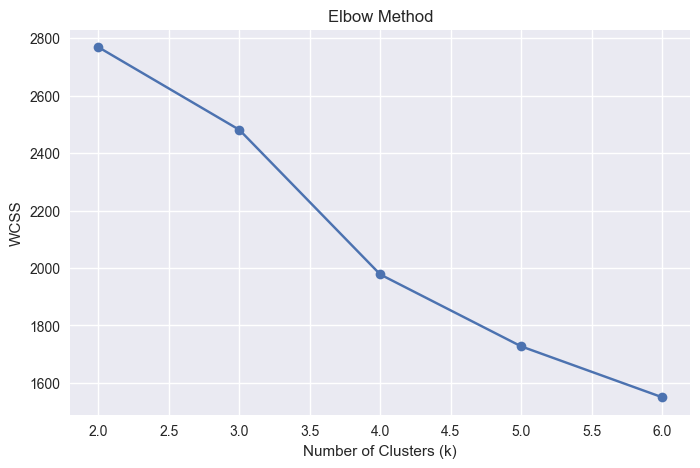

In [31]:
wcss = []
K = range(2, 7)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, wcss, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

k=2, Silhouette Score = 0.2143
k=3, Silhouette Score = 0.2249
k=4, Silhouette Score = 0.2523
k=5, Silhouette Score = 0.2570
k=6, Silhouette Score = 0.2780


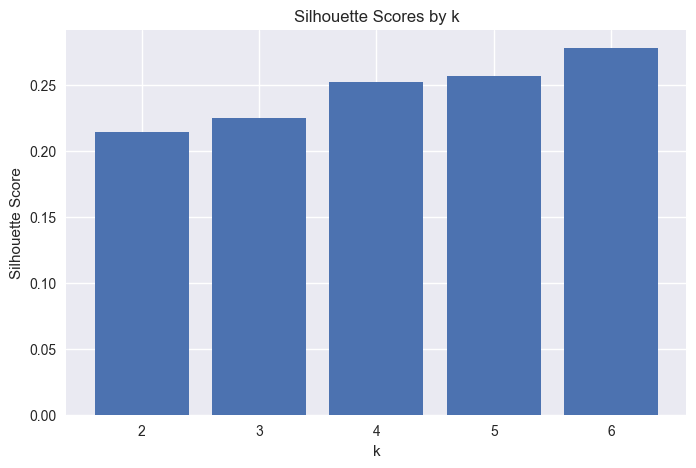

In [32]:
sil_scores = []

for k in K:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(scaled_data)
    sil = silhouette_score(scaled_data, labels)
    sil_scores.append(sil)
    print(f"k={k}, Silhouette Score = {sil:.4f}")

plt.figure(figsize=(8, 5))
plt.bar(K, sil_scores)
plt.title("Silhouette Scores by k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.show()

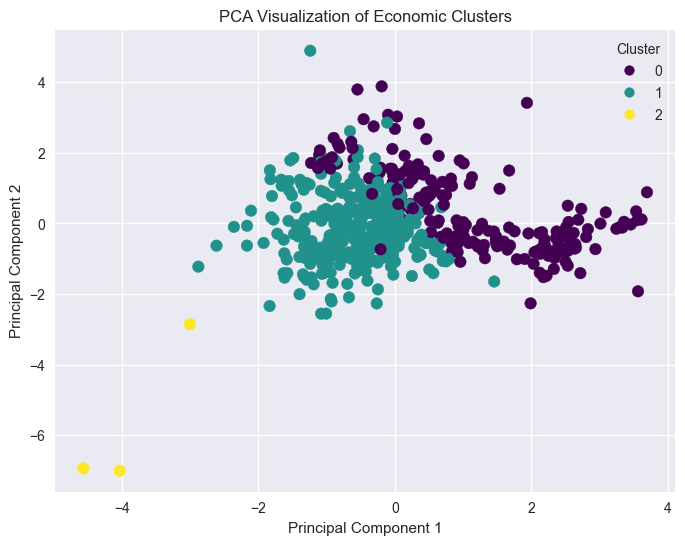

In [33]:
k_opt = 3
kmeans_final = KMeans(n_clusters=k_opt, random_state=42)
cluster_labels = kmeans_final.fit_predict(scaled_data)

df_cluster = df_cluster.copy()
df_cluster["Cluster"] = cluster_labels

# -------------------------------------------
# PCA VISUALIZATION
# -------------------------------------------
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    pca_data[:, 0],
    pca_data[:, 1],
    c=df_cluster["Cluster"],
    cmap="viridis",
    s=70
)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Visualization of Economic Clusters")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()




Cluster summary (mean values):
         Inflation (CPI %)  GDP per Capita (Current USD)  \
Cluster                                                    
0                 2.584010                  33821.696093   
1                 5.401048                   7135.668144   
2                53.716100                   5191.783046   

         GDP Growth (% Annual)  Unemployment Rate (%)  \
Cluster                                                 
0                     0.580068               9.372927   
1                     4.126986               7.101736   
2                    -0.838387               7.036000   

         Interest Rate (Real, %)  Public Debt (% of GDP)  
Cluster                                                   
0                       4.855195               80.506417  
1                       5.726183               43.443950  
2                     -25.861721               44.701654  


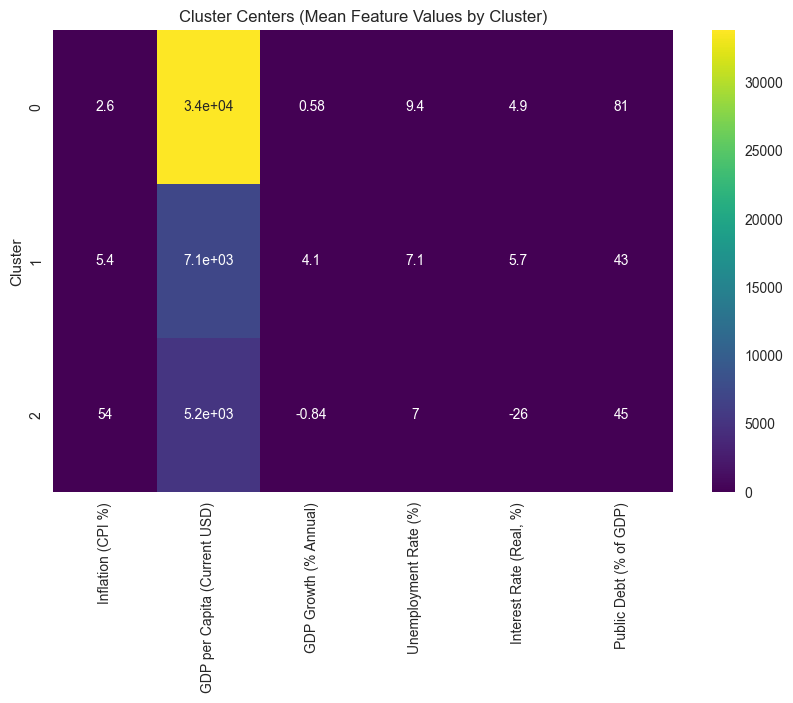

In [34]:
cluster_summary = df_cluster.groupby("Cluster")[features].mean()
print("\nCluster summary (mean values):")
print(cluster_summary)

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_summary, annot=True, cmap="viridis")
plt.title("Cluster Centers (Mean Feature Values by Cluster)")
plt.show()